In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
                            recall_score, f1_score, log_loss, precision_recall_curve

from catboost import CatBoostClassifier

import optuna

import yaml

In [2]:
def get_metrics(y_test, y_pred, y_score, name = "Default"):
    """Метрики для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred, zero_division=0)
    df_metrics['Recall'] = recall_score(y_test, y_pred, zero_division=0)
    df_metrics['f1'] = f1_score(y_test, y_pred, zero_division=0)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [3]:
def open_file(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    
def save_file(file_path, data):       
    with open(file_path, 'w') as file:
        yaml.dump(data, file)

In [22]:
config_path = "../config/params.yaml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc = config["preprocessing"]
train = config['train']

In [5]:
model_params_path = "../config/model_params/catboost.yaml"

# Baseline

In [8]:
df_train = pd.read_csv(preproc['train_data'])
df_train = df_train.set_index('index')

df_train[:5]

,purchase,forsmallbiz,price,customer,supplier,is_winner,vectorized_tokens,month,reg_code,purchase_size,flag_won,n_unique_okpd2
index,,,,,,,,,,,,
0,3,1,290000.00,2,1,1,[ 0.18815488 0.1963165 0.08348706 0.132998...,2,58.2_2,1,0.0,4
1,2834,1,105000.00,218,1,1,[ 1.88778124e-01 1.99460707e-01 8.44090815e-...,2,62.0_2,1,0.0,4
2,154949,1,98967.50,11235,1,1,[ 0.17555872 0.0838882 0.01939559 0.047119...,2,63.9_2,1,0.0,4
3,147950,0,77460.03,11061,1,1,[ 2.09548737e-01 1.98348963e-01 3.00821184e-...,3,62.0_2,1,0.0,4
4,165990,0,138000.00,11558,1,1,[ 1.55703006e-01 1.47389050e-01 4.36386056e-...,3,62.0_2,1,0.0,4


In [9]:
df_test = pd.read_csv(preproc['test_data'])
df_test = df_test.set_index('index')

df_test[:5]

,purchase,forsmallbiz,price,customer,supplier,is_winner,vectorized_tokens,month,reg_code,purchase_size,flag_won,n_unique_okpd2
index,,,,,,,,,,,,
0,1064,1,181720.00,70,1,1,[ 1.77900028e-01 8.02768195e-02 1.25833983e-...,11,58.2_2,1,0.0,4.0
1,1729,1,167448.00,105,1,1,[ 2.70711475e-01 8.42926477e-02 4.42017172e-...,12,62.0_2,1,0.0,4.0
2,2430,1,200248.16,201,1,1,[ 2.59523023e-01 1.20019309e-01 7.98608701e-...,12,62.0_2,1,0.0,4.0
3,156898,0,190740.00,11266,1,1,[ 0.20131386 0.07292083 -0.01833528 -0.017387...,12,62.0_2,1,0.0,4.0
4,412017,1,2886156.00,9651,100009,0,[ 5.40626203e-02 7.06050537e-02 -3.14055514e-...,11,27.4_77,1,0.0,1.0


In [10]:
df_train = df_train.astype(preproc['change_type_columns'])
df_test = df_test.astype(preproc['change_type_columns'])

In [11]:
df_train = df_train.drop(columns=train['drop_columns_catboost'])
df_test = df_test.drop(columns=train['drop_columns_catboost'])

In [12]:
df_train[:5]

,forsmallbiz,price,supplier,is_winner,month,reg_code,purchase_size,flag_won,n_unique_okpd2
index,,,,,,,,,
0,1,290000.00,1,1,2,58.2_2,1,0.0,4
1,1,105000.00,1,1,2,62.0_2,1,0.0,4
2,1,98967.50,1,1,2,63.9_2,1,0.0,4
3,0,77460.03,1,1,3,62.0_2,1,0.0,4
4,0,138000.00,1,1,3,62.0_2,1,0.0,4


In [13]:
df_test[:5]

,forsmallbiz,price,supplier,is_winner,month,reg_code,purchase_size,flag_won,n_unique_okpd2
index,,,,,,,,,
0,1,181720.00,1,1,11,58.2_2,1,0.0,4.0
1,1,167448.00,1,1,12,62.0_2,1,0.0,4.0
2,1,200248.16,1,1,12,62.0_2,1,0.0,4.0
3,0,190740.00,1,1,12,62.0_2,1,0.0,4.0
4,1,2886156.00,100009,0,11,27.4_77,1,0.0,1.0


In [15]:
X = df_train.drop('is_winner', axis=1)
Y = df_train['is_winner']

In [26]:
x_test = df_test.drop('is_winner', axis=1)
y_test = df_test['is_winner']

In [16]:
metrics = pd.DataFrame()

In [41]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(X, Y,
                                                      test_size=train['test_size'],
                                                      stratify=Y,
                                                      random_state=train['random_state'])

ratio = y_val_[y_val_ == 0].shape[0] / y_val[y_val_ == 1].shape[0]

In [42]:
model = CatBoostClassifier(random_state=train['random_state'], 
                           scale_pos_weight=ratio,
                           eval_metric='AUC',
                           cat_features=train['cat_features'])

model.fit(x_train_, y_train_,
          eval_set=[(x_val_, y_val_)],
          early_stopping_rounds=100,
          verbose=0)

In [43]:
y_pred = model.predict(x_train_)
y_score = model.predict_proba(x_train_)

metrics = pd.concat([metrics, get_metrics(y_train_, y_pred, y_score, 
                                          'Catboost_baseline_train')])

In [44]:
y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

metrics = pd.concat([metrics, get_metrics(y_test, y_pred, y_score, 
                                          'Catboost_baseline_test')])

In [45]:
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Catboost_baseline_train,0.872283,0.956335,0.967213,0.667925,0.790179,0.380774
0,Catboost_baseline_train,0.872283,0.956335,0.967213,0.667925,0.790179,0.380774
0,Catboost_baseline_test,0.670886,0.716755,0.714286,0.312500,0.434783,0.611119
0,Catboost_baseline_train,0.831522,0.948908,0.986207,0.539623,0.697561,0.414263
0,Catboost_baseline_test,0.683544,0.630984,0.888889,0.250000,0.390244,0.622094


# Tune

In [18]:
def objective(trial: optuna.Trial, x: pd.DataFrame, y: pd.Series) -> float:

    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [1000]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.07284883468764865]),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 100),
        'random_strength': trial.suggest_float('random_strength', 10, 50),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 100),
        'border_count': trial.suggest_categorical('border_count', [128]),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'use_best_model': trial.suggest_categorical('use_best_model', [True]),
        'eval_metric': trial.suggest_categorical('eval_metric', ['AUC']),
        'random_state': train['random_state']
    }

    cv_pred = np.empty(train['N_FOLDS'])
    cv = StratifiedKFold(n_splits=train['N_FOLDS'], shuffle=True, random_state=train['random_state'])

    for fold, (train_idx, test_idx) in enumerate(cv.split(x, y)):
        x_train_, x_val_ = x.iloc[train_idx], x.iloc[test_idx]
        y_train_, y_val_ = y.iloc[train_idx], y.iloc[test_idx]
        
        ratio = y_train_[y_train_ == 0].shape[0] / \
            y_train_[y_train_ == 1].shape[0]
        
        model = CatBoostClassifier(
            scale_pos_weight=ratio,
            cat_features=['supplier', 'reg_code'],
            **params
        )
        model.fit(x_train_, y_train_,
                  eval_set=[(x_val_, y_val_)],
                  early_stopping_rounds=100,
                  verbose=0)

        y_pred = model.predict(x_val_)
        y_proba = model.predict_proba(x_val_)[:, 1]

        cv_pred[fold] = roc_auc_score(y_val_, y_proba)
    return (np.mean(cv_pred))

In [19]:
func = lambda trial: objective(trial, x_train, y_train)

study = optuna.create_study(direction="maximize")
study.optimize(func, show_progress_bar=True, n_trials=10, n_jobs=4)

[I 2023-04-09 14:21:11,967] A new study created in memory with name: no-name-5a18e482-6dc7-4938-addd-339812ca3b29
/home/sergey/virtual_env/lib/python3.10/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-04-09 14:59:25,683] Trial 3 finished with value: 0.864094485206935 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07284883468764865, 'depth': 7, 'l2_leaf_reg': 50.631900469317344, 'random_strength': 45.836994263457285, 'bagging_temperature': 12.543409960120233, 'border_count': 128, 'grow_policy': 'Depthwise', 'use_best_model': True, 'eval_metric': 'AUC'}. Best is trial 3 with value: 0.864094485206935.
[I 2023-04-09 15:10:16,549] Trial 2 finished with value: 0.8639963249014325 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07284883468764865, 'depth': 6, 'l2_leaf_reg': 52.787500980630625, 'random_strength': 22.460874249242377, 'bagging_temperature': 71.29136844674768, 'border_count': 128, 'grow_policy': 'Depthwise', 'use_best_model': True, 'eval_metric': 'AUC'}. Best is trial 3 with value: 0.864094485206935.
[I 2023-04-09 15:18:08,645] Trial 1 finished with value: 0.8640657732335257 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07284883468764865,

In [20]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.07284883468764865,
 'depth': 10,
 'l2_leaf_reg': 39.72475205414329,
 'random_strength': 32.970336292743085,
 'bagging_temperature': 8.120201363140767,
 'border_count': 128,
 'grow_policy': 'SymmetricTree',
 'use_best_model': True,
 'eval_metric': 'AUC'}

In [26]:
save_file(model_params_path, study.best_params)

# Calibration

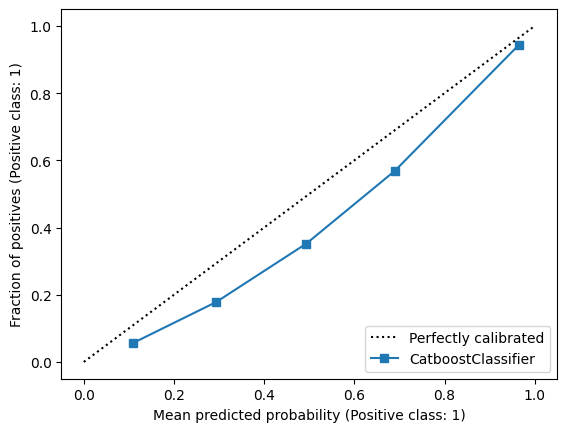

In [28]:
display = CalibrationDisplay.from_estimator(
    model,
    # данные для калибровки
    x_val_,
    y_val_,
    # кол-во бинов
    n_bins=5,
    # модель
    name="CatboostClassifier",
)

In [24]:
cat_iso = CalibratedClassifierCV(model, cv='prefit', method='isotonic')

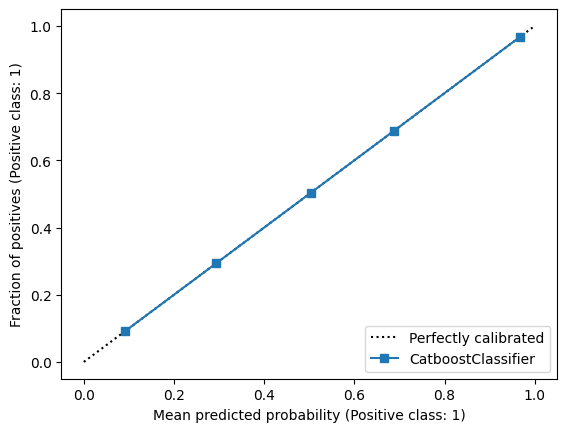

In [27]:
cat_iso.fit(x_val_, y_val_)

display = CalibrationDisplay.from_estimator(
    cat_iso,
    # данные для калибровки
    x_val_,
    y_val_,
    # кол-во бинов
    n_bins=5,
    # модель
    name="CatboostClassifier",
)